## Export recomposed signals to matlab

In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

import scipy.signal as signal
import matplotlib.pyplot as plt

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Loading files names

In [5]:
def loadFile(file_name, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(csv_dir, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [7]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [8]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [9]:
def accmag(data, suptitle="Magnitude of accelerometer signal", feature='activity', plt_win_func=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = [x/16384.0 for x in data[count]["accX"].dropna()]
                norm_dataY = [y/16384.0 for y in data[count]["accY"].dropna()]
                norm_dataZ = [z/16384.0 for z in data[count]["accZ"].dropna()]

                mag = []
                for i in range(len(norm_dataX)):
                    mag.append(np.sqrt(norm_dataX[i]**2 + norm_dataY[i]**2 + norm_dataZ[i]**2))

                windowFunction = np.hanning(len(mag))
                #if use_win_func:
                #    mag = mag * np.hanning(len(mag))

                row[j].set_title("W={}. {}={} ".format(count, feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('Vector magnitude')
                row[j].plot(mag, label=str(data[count][feature][0]))
                row[j].plot(windowFunction, label="hanning")
                row[j].grid()
                if plt_win_func:
                    row[j].plot(mag * np.hanning(len(mag)), label="combined")
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()

def running_mean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def compute_runavg_acc(data, showPlot= False, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    

    ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
    # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
    norm_dataX = running_mean(data, N)
    
    if showPlot:
        fig, ax = plt.subplots(1,1, figsize=(18,8))
        N_samps = len(norm_dataX)
        Fs = N_samps/time_interval
        print "Time interval: ", str(time_interval)
        # the period represents the oscilation. It's  the sample time, the time after which each data come.
        T = 1./Fs
        print "Period: {}".format(T)

        t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

        ax.set_ylabel('g\'s (9.8 m/s^2)')
        ax.plot(norm_dataX)
        ax.grid()
        #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)

        plt.draw()
    
    return norm_dataX

Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
-- Retrieved 24 windows in _2016-11-23-18-49-13_exp1_Player.csv

Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
-- Retrieved 28 windows in _2016-11-23-18-49-13_exp2_Player.csv

Processing: "_2016-11-23-18-49-13_exp3_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp3_Player.csv"
-- Retrieved 12 windows in _2016-11-23-18-49-13_exp3_Player.csv

Processing: "_2016-11-23-18-49-13_exp4_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp4_Player.csv"
-- Retrieved 23 windows in _2016-11-23-18-49-13_exp4_Player.csv

Processing: "_2016-11-23-18-49-13_exp5_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp5_Player.csv"
-- Retrieved 27 windows in _2016-11-23-18-49-13_exp5_Player.csv

Processing: "_2016-11-24-15-43-37_exp1d_Player.csv"
-- Processing: "_2016-11-24-15-43-37_exp1d_Player.csv"
-- Retrieved 31 windows in _2016-11-24-15-4

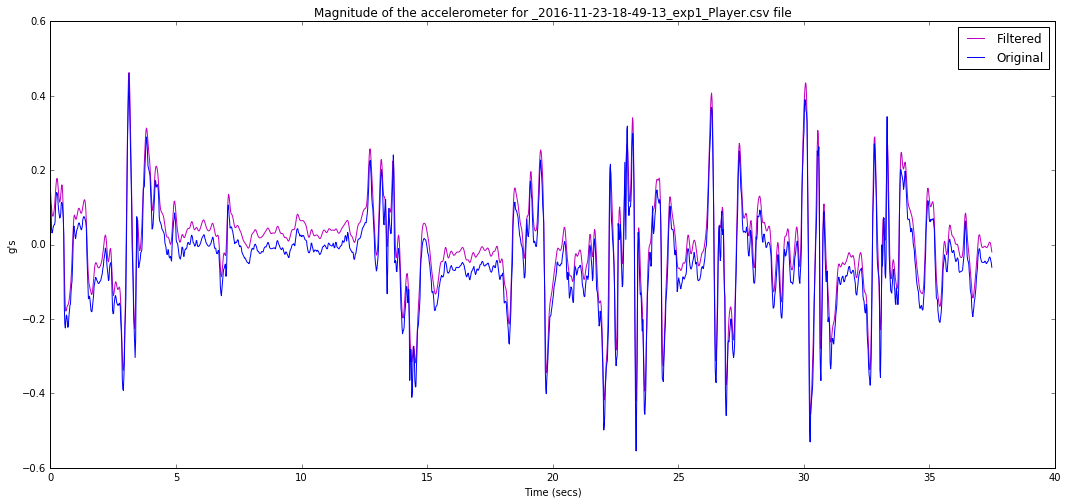

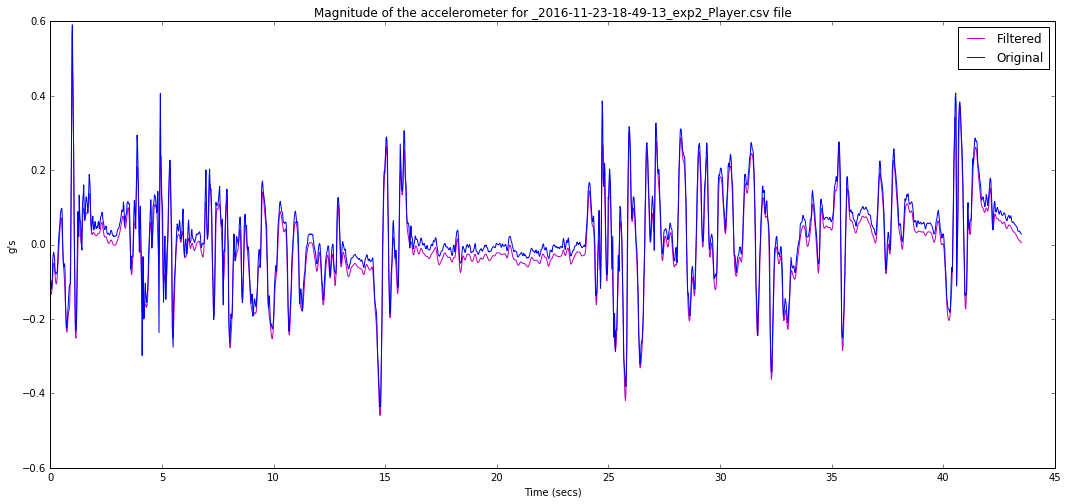

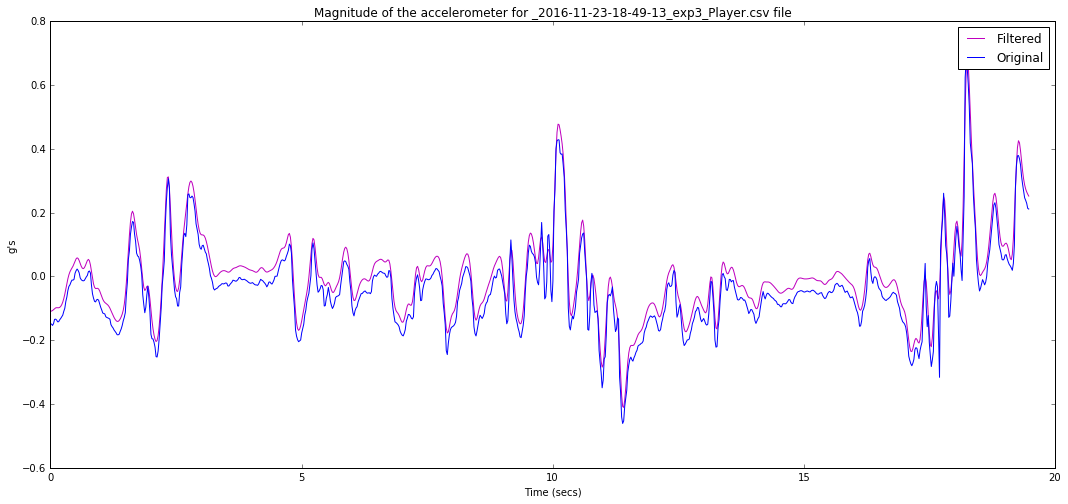

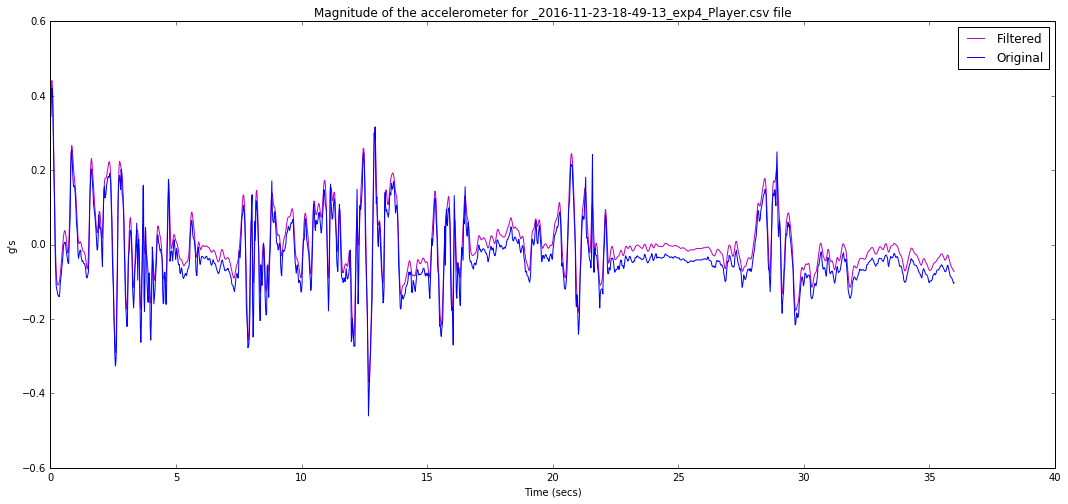

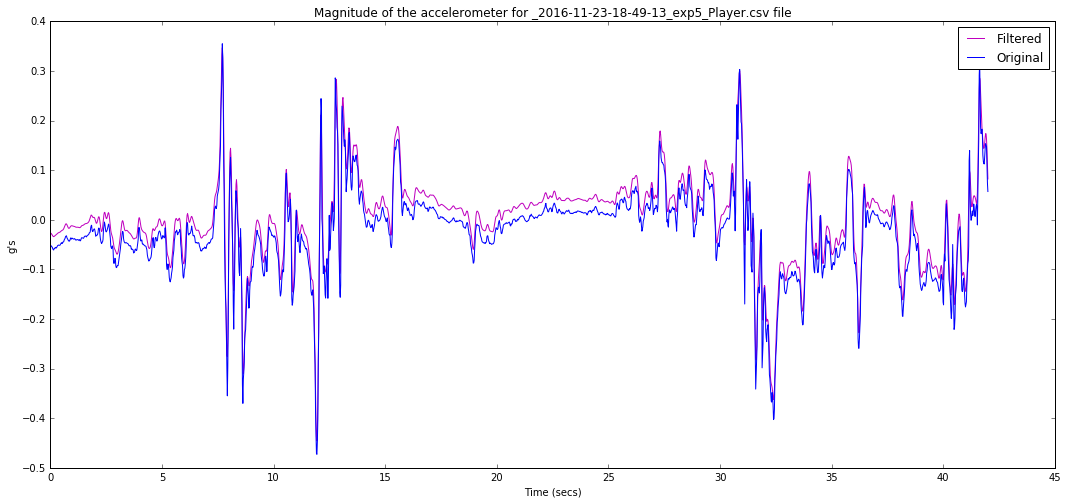

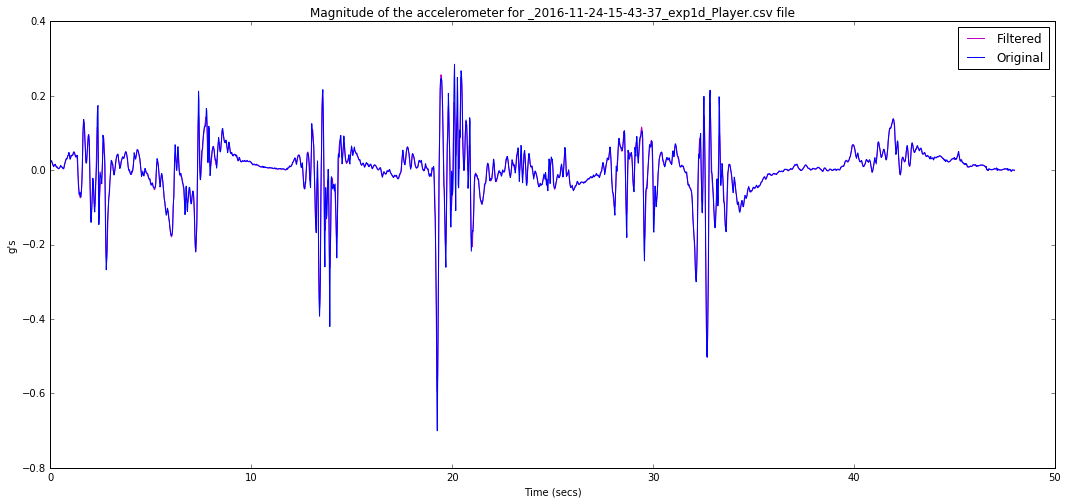

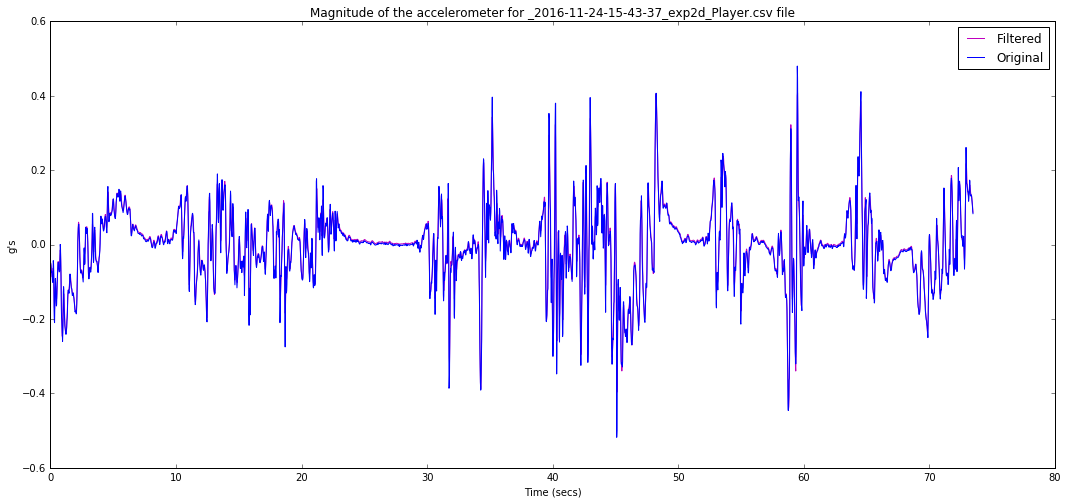

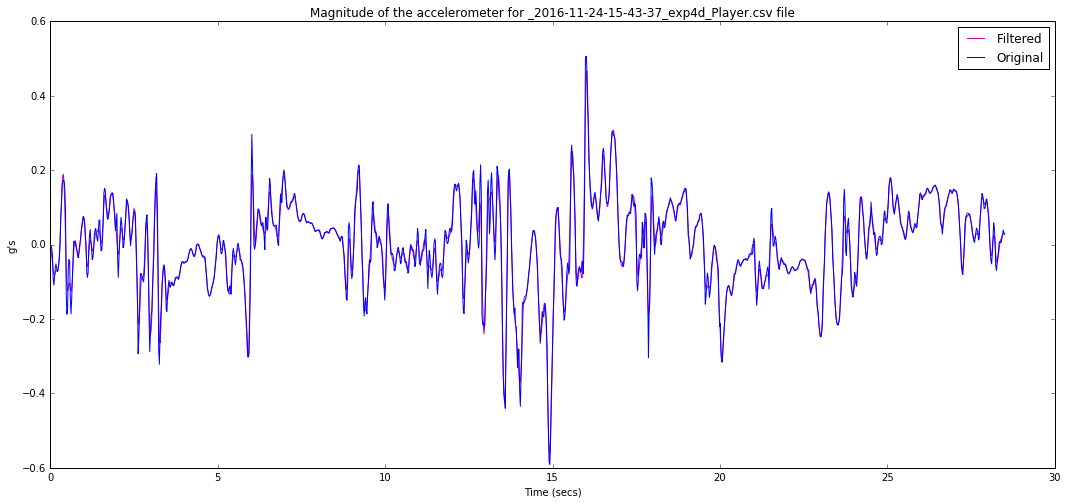

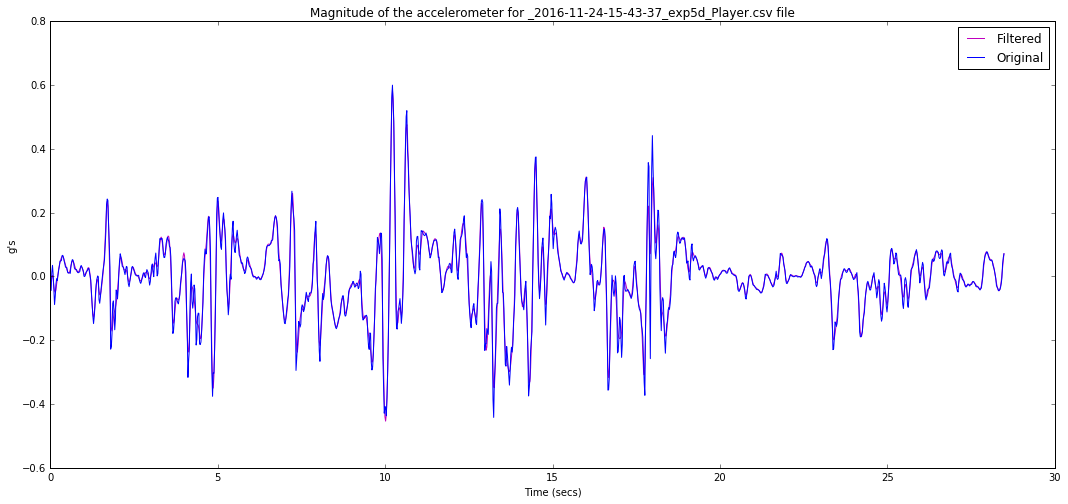

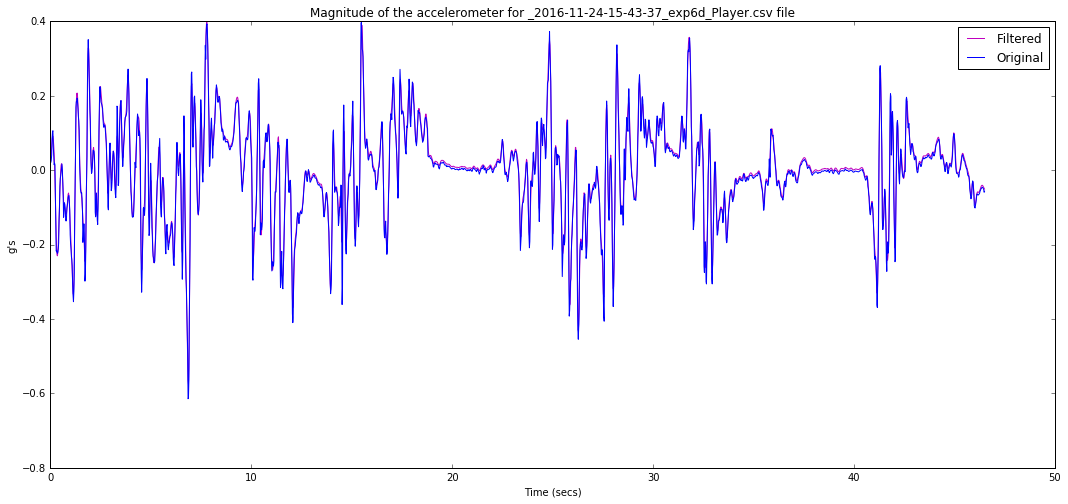

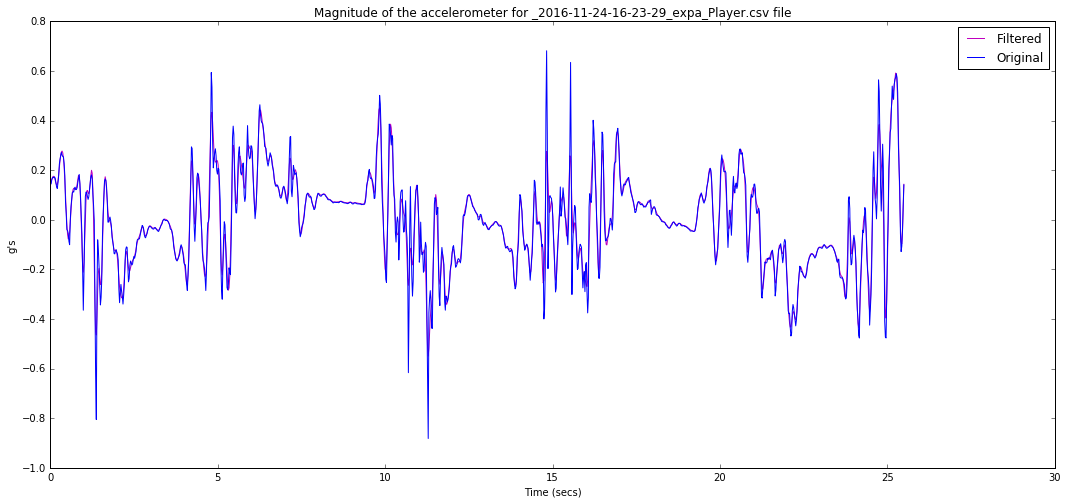

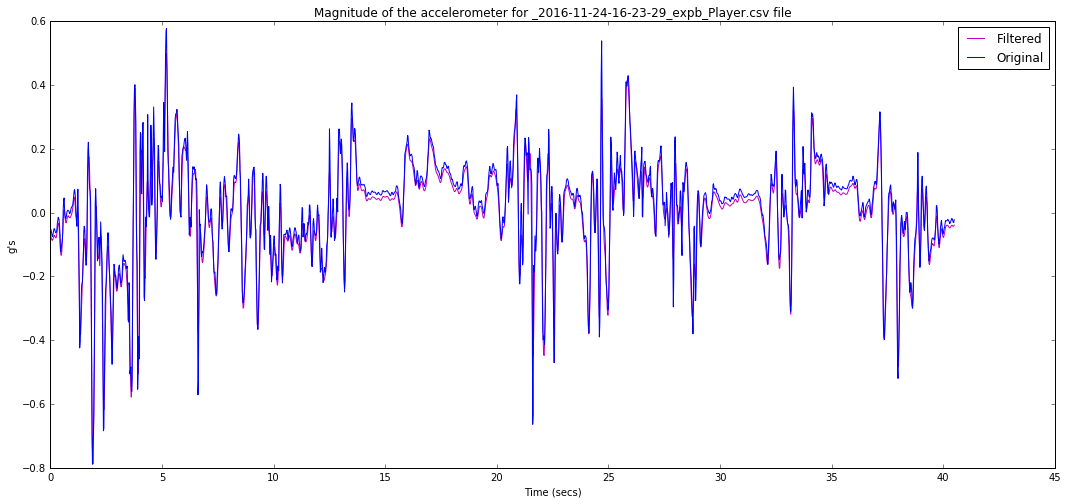

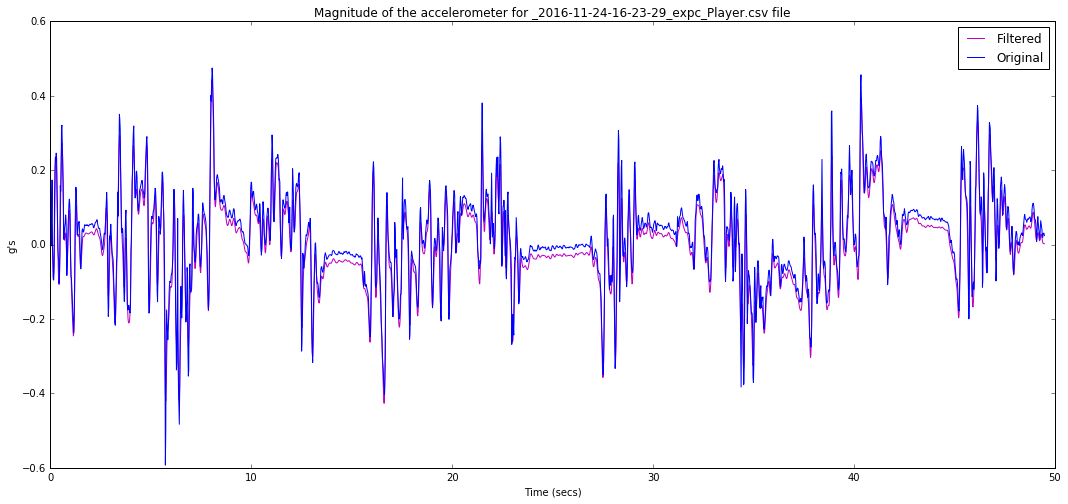

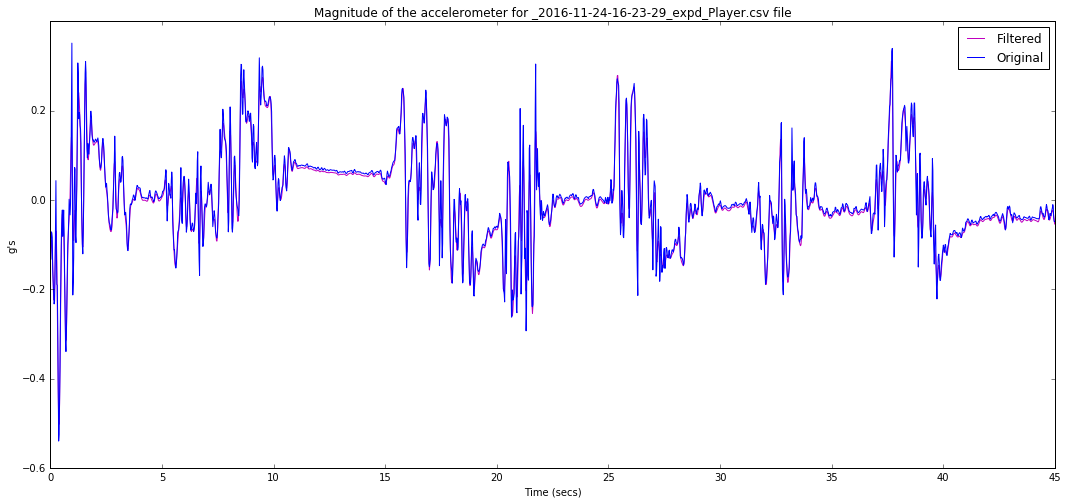

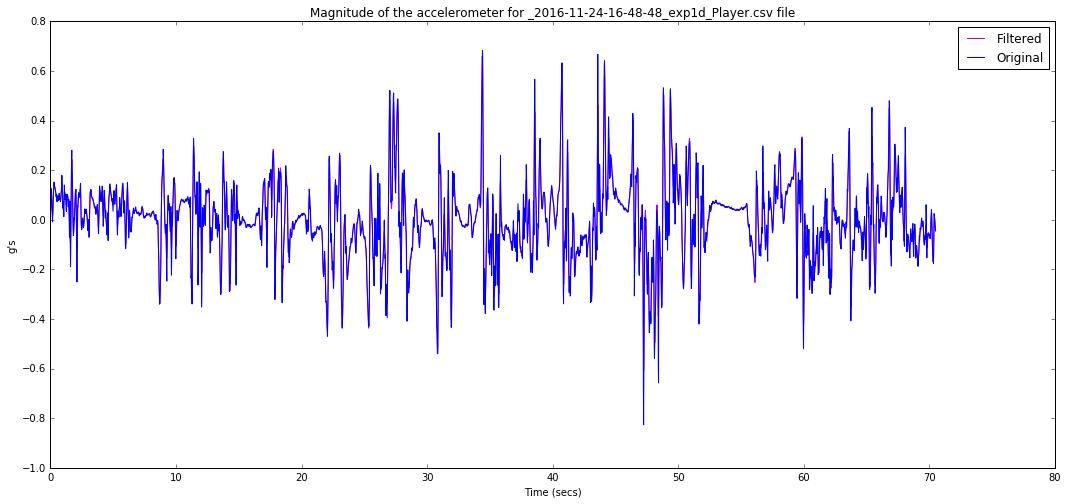

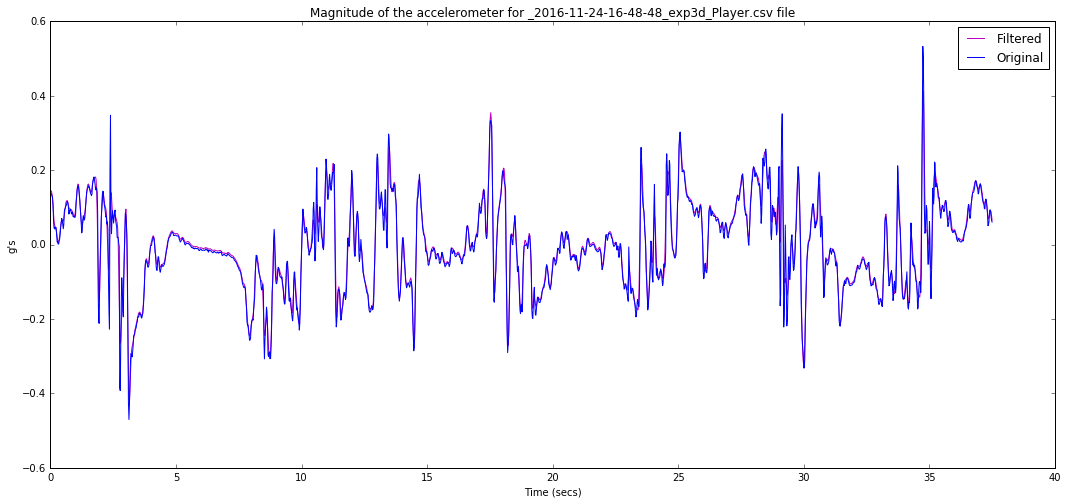

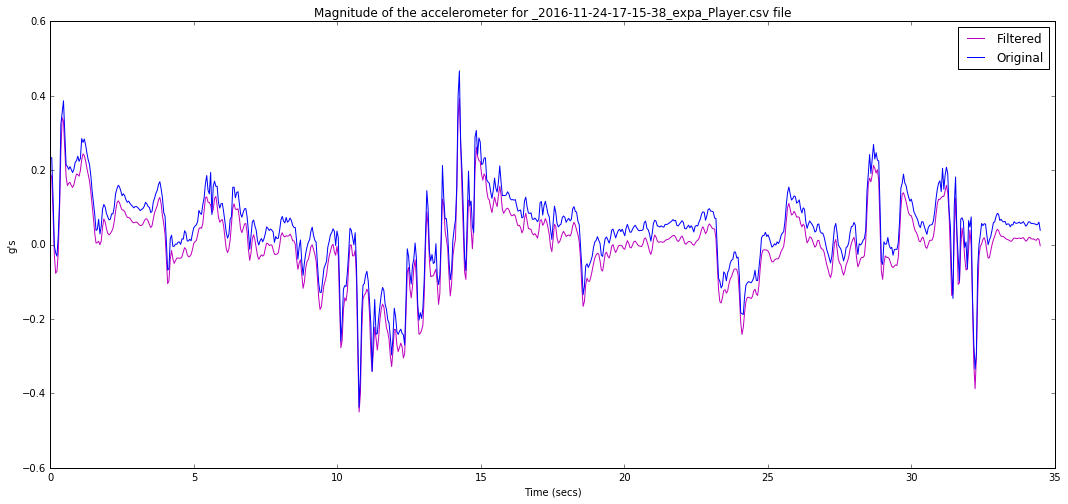

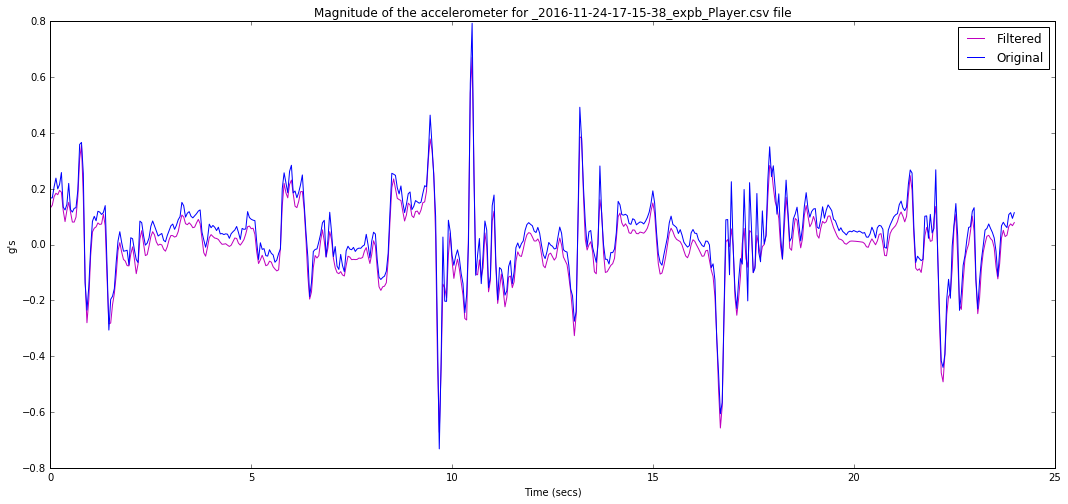

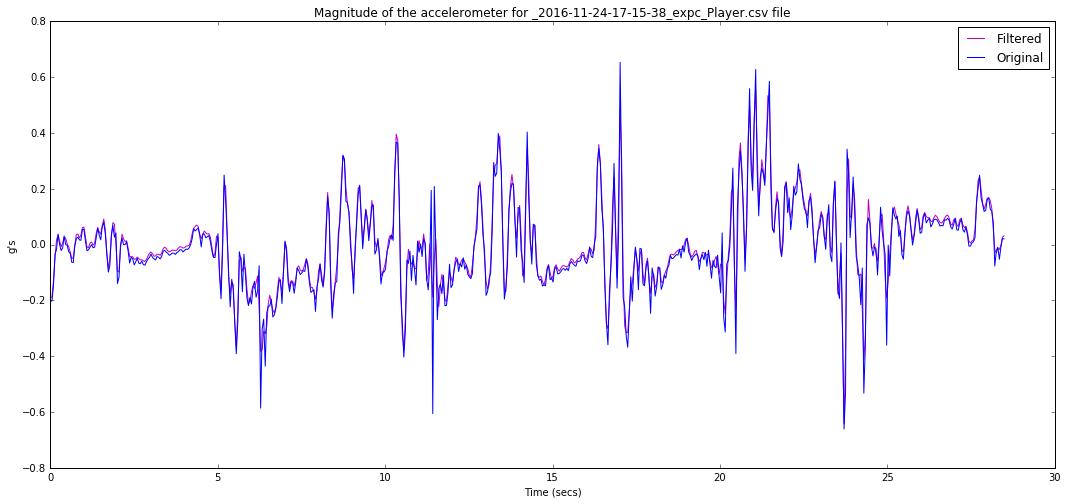

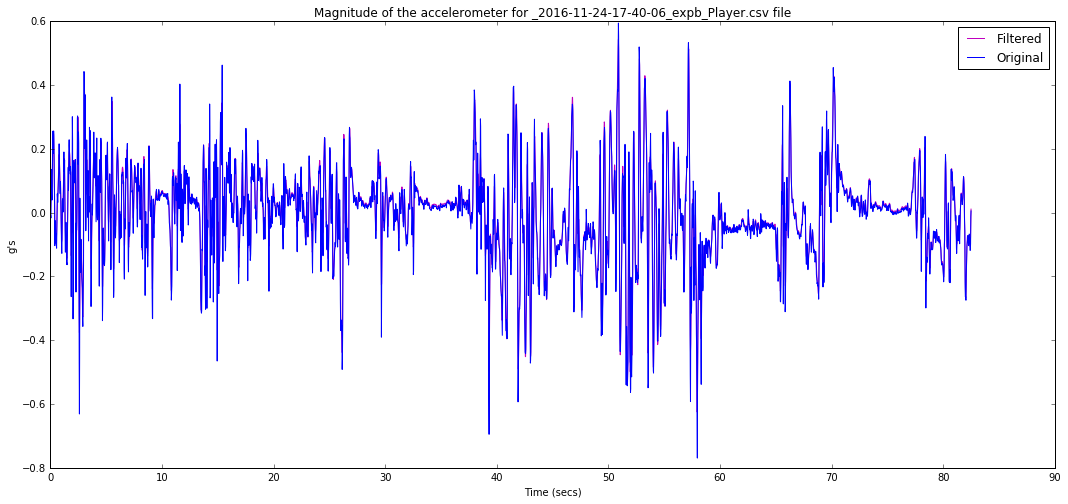

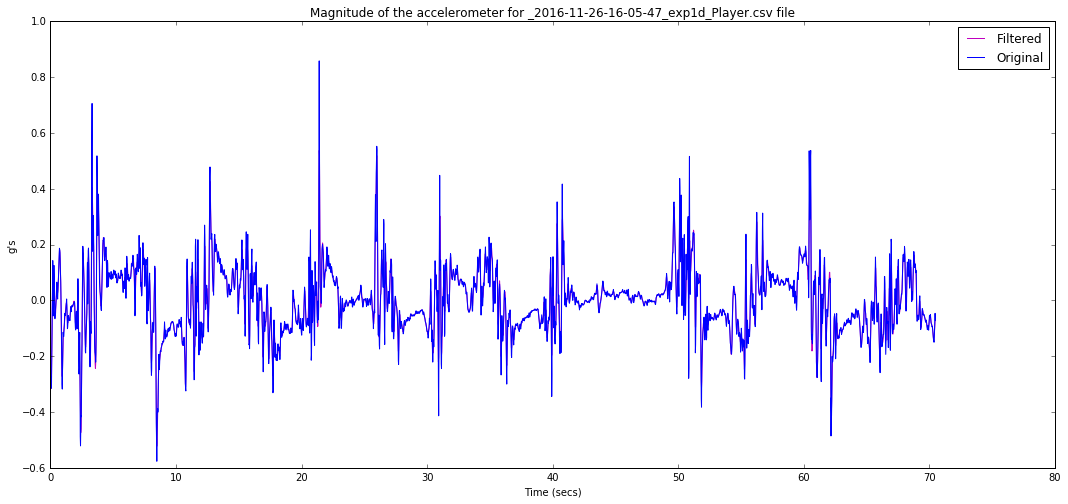

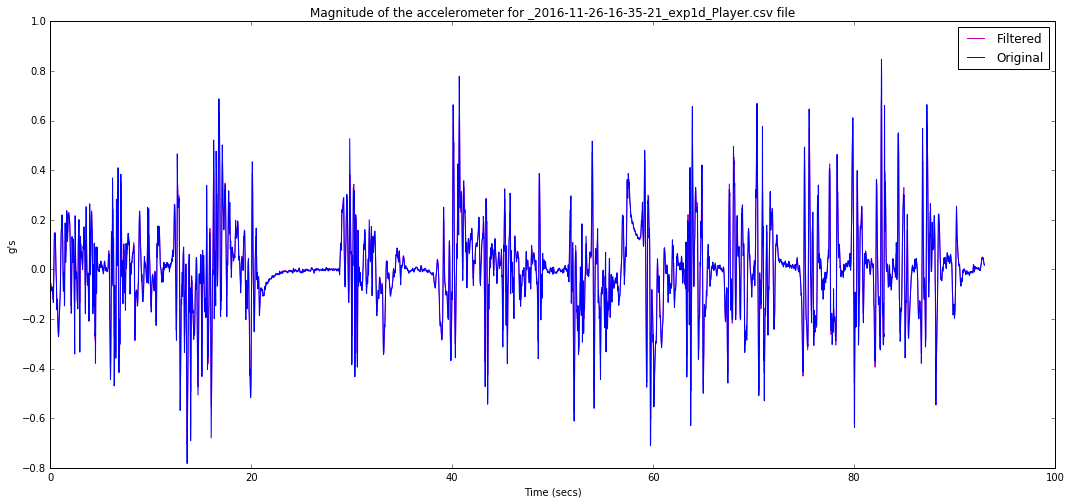

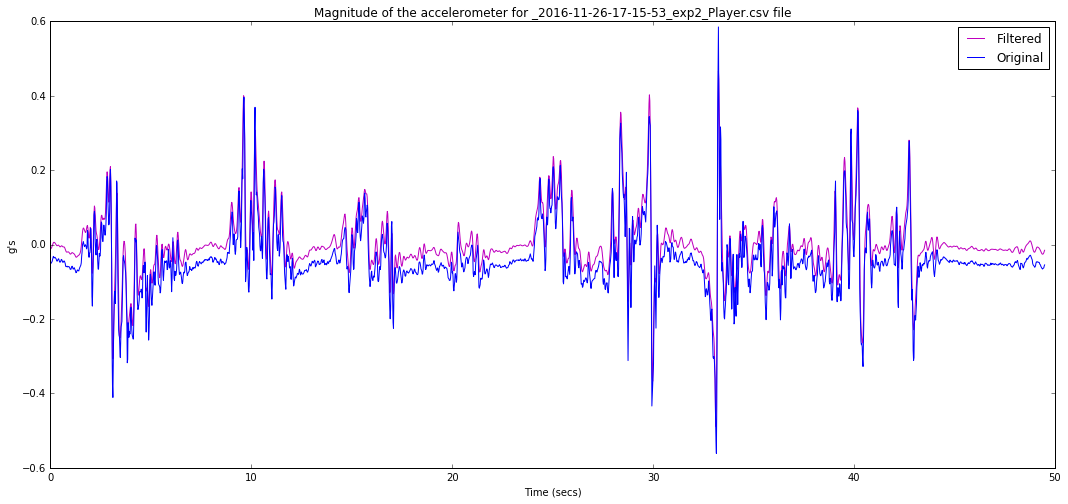

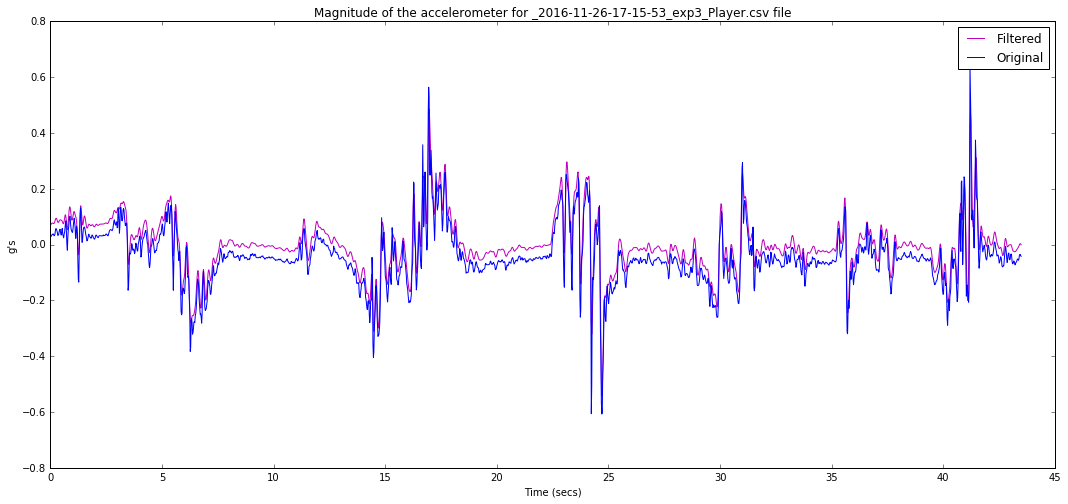

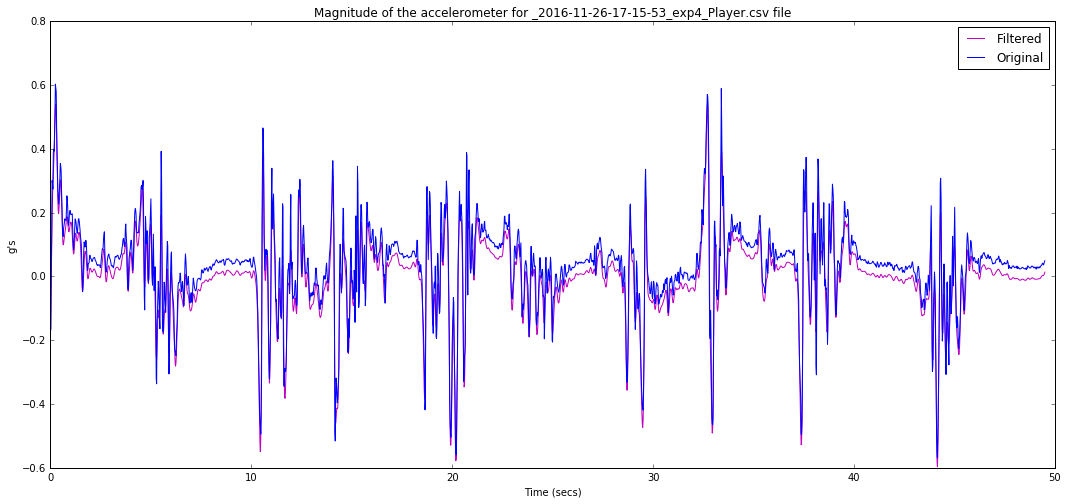

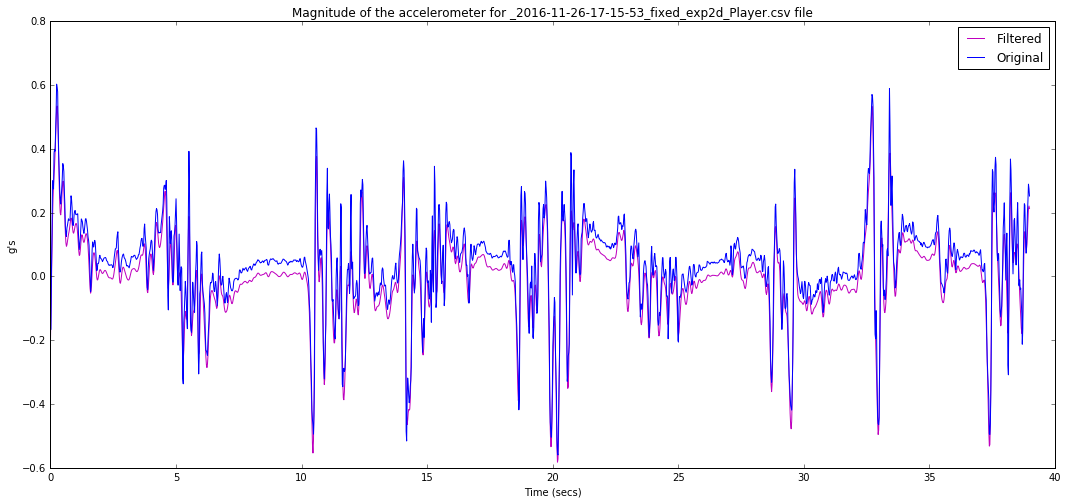

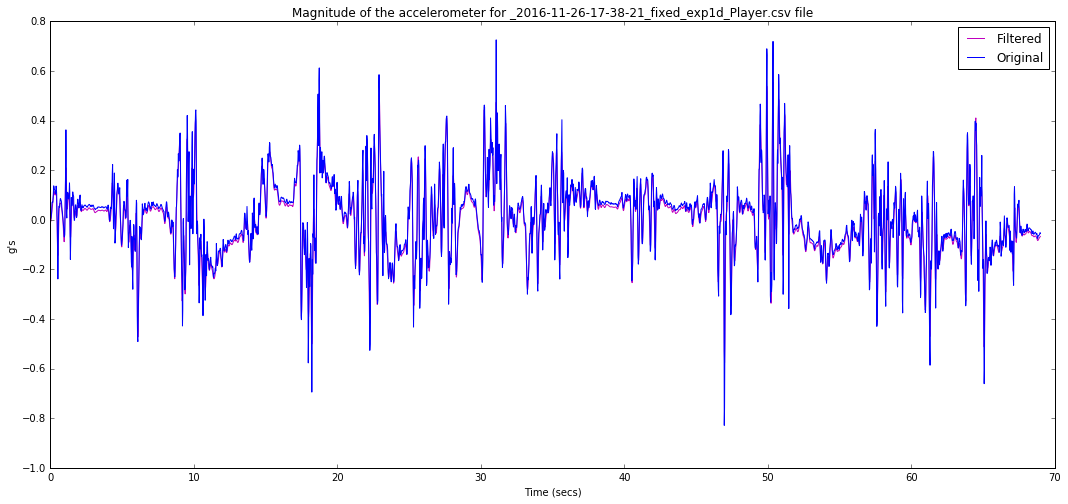

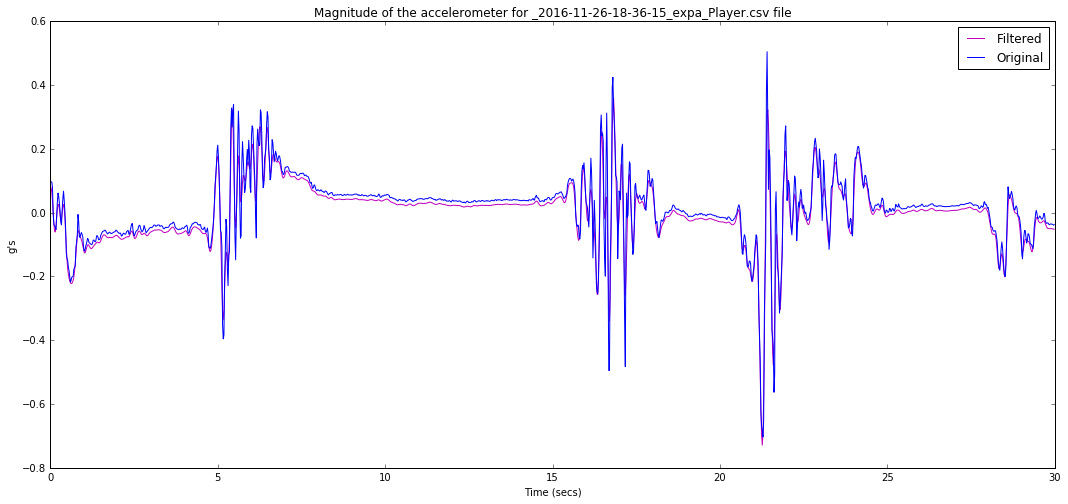

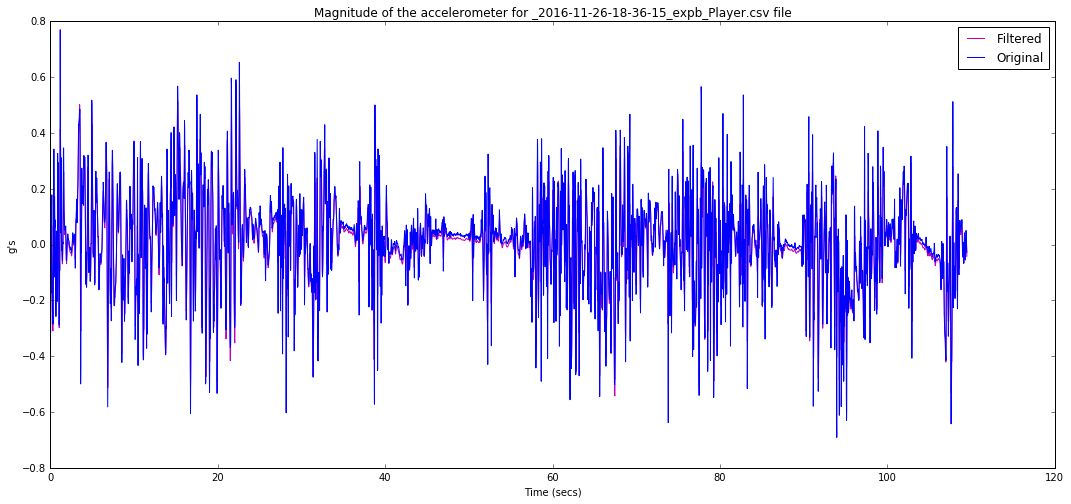

In [17]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)
failed_files = []
frequences = []

for f in files:
    csv_filename = f
    file_data = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    print 'Processing: "{}"'.format(csv_filename)

    # load the data, abort in case of error.
    try:
        file_data = loadFile(csv_filename)
    except ValueError as e:
        print traceback.format_exc()
        failed_files.append(csv_filename)
        continue

    #### Normalize to g's accelerometer axis ####
    allAccX = []
    allAccY = []
    allAccZ = []
    time_interval = 0
    #print '-- Normalizing accelerometer data...'
    for i, w in enumerate(file_data):
        if i==0:
            for x, y, z in zip(w['accX'].dropna().as_matrix(), w['accY'].dropna().as_matrix(), w['accZ'].dropna().as_matrix()):
                allAccX.append(x/16384.0)
                allAccY.append(y/16384.0)
                allAccZ.append(z/16384.0)
        else:
            values = list(set(w['time']) - set(file_data[i-1]['time']))
            time_interval = w['time'].iloc[-1]
            result = w[w['time'].isin(values)]
            for x, y, z in zip(result['accX'].dropna().as_matrix(), result['accY'].dropna().as_matrix(), result['accZ'].dropna().as_matrix()):
                allAccX.append(x/16384.0)
                allAccY.append(y/16384.0)
                allAccZ.append(z/16384.0)
    
    
    N_samps = len(allAccX)
    Fs = N_samps/time_interval
    frequences.append(Fs)
    
    ##### COMPUTING THE AC COMPONENT  (Transformation I: Offset Translation) ####
    dataX_AC = np.array(allAccX) - np.mean(allAccX)
    dataY_AC = np.array(allAccY) - np.mean(allAccY)
    dataZ_AC = np.array(allAccZ) - np.mean(allAccZ)
    ####
    
    #### Transformation II: Amplitude Scaling ####
    dataX_Scaled = dataX_AC #(dataX_AC - np.mean(dataX_AC)) / np.std(dataX_AC)
    dataY_Scaled = dataY_AC #(dataY_AC - np.mean(dataY_AC)) / np.std(dataY_AC)
    dataZ_Scaled = dataZ_AC #(dataZ_AC - np.mean(dataZ_AC)) / np.std(dataZ_AC)
    
    ##### SMOOTH USING BUTTERWORTH FILTER #####
    # Butterworth filter properties
    # Correct the cutoff frequency for the number of passes in the filter
    C = 0.802
    freq = Fs   # Calculating frequency
    b, a = butter(3, (5/C)/(freq/2), btype = 'low') # BF order 3
    # applying butterworth filter for x axis, filter with phase shift correction
    dataX_filtered = filtfilt(b, a, dataX_Scaled)
    dataY_filtered = filtfilt(b, a, dataY_Scaled)
    dataZ_filtered = filtfilt(b, a, dataZ_Scaled)
    ####

    #### COMPUTE MAGNITUDE VECTOR #####
    #mag = []
    #for i in range(len(norm_dataX)): #all tree axis data are the same length
    #    mag.append(np.sqrt(norm_dataX[i]**2 + norm_dataY[i]**2 + norm_dataZ[i]**2))
    
    ##### SMOOTH MAGNITUDE USING RUNNING AVERAGE #####
    #vect = compute_runavg_acc(vect, N=12)
    
    ##### computing jerk #####
    #jerk = []
    #for i in range(len(vect)):
    #    if i-1 < 0:
    #        jerk.append(vect[i])
    #    else:
    #        jerk.append(vect[i] - vect[i-1])
            
    ##### SMOOTH MAGNITUDE USING RUNNING AVERAGE #####
    #jerk = compute_runavg_acc(jerk, N=8)
    
    ### PLOTTING SIGNAL ####
    #print "-- Time interval: ", str(time_interval)
    ## the period represents the oscilation. It's  the sample time, the time after which each data come.
    T = 1./Fs
    t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
    fig, ax = plt.subplots(1,1, figsize=(18,8))
    #ax.plot(t,dataX_Scaled, c='g', label='Scaled')
    #ax.plot(t,dataX_AC, c='r', label='AC')
    ax.plot(t,dataX_filtered, c='m', label='Filtered')
    ax.plot(t,allAccX, c='b', label='Original')
    #ax.plot(t,norm_dataZ, c='r', label='Z')
    ax.set_ylabel("g's")
    #ax.set_ylim(0,0.05)
    ax.set_xlabel('Time (secs)')
    plt.title("Magnitude of the accelerometer for {} file".format(csv_filename))
    plt.legend()
    #plt.yscale('log')
    plt.draw()

    
    #sys.exit(0)
    
    #### SAVE TO .MAT #####
    #save_to_dir = './mat_xyz_files_preprocessed'
    #name_to_save = os.path.join(save_to_dir,'{}.mat'.format(csv_filename))
    #print '-- Saving to: {}'.format(name_to_save)
    #sio.savemat(name_to_save, {'x_axis':dataX_filtered,'y_axis':dataY_filtered,'z_axis':dataZ_filtered})
    print

print 'DONE!'
#print 'Files average frequency of {} with std. deviation of {}'.format(np.mean(frequences),np.std(frequences))